# Ray refraction

This workbook completes our journey through the mathematics of ray tracing. In it we will recap and visualise the effects when the refractive index of an object causes a ray to **refract** or bend upon entering or exiting. To do this we will use many of the python tools we have already generated to work with maths and rays.

In [1]:
## Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

Arrows for vectors are handy:

In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

## Background

In the lectures we saw that the path of a ray can change after entering or leaving an object. This change is caused by the change in the speed of light at a boundary/interface; a way to capture this change in behaviour is found in the refractive index, $\mu$, which is a ratio of the speed of light in a medium to the speed of light in a vacuum. If the ray leaves air to enter a medium, $\mu>1$; if the ray leaves a medium to enter air, $\mu<1$. 

It can also be useful to remember that if a ray enters *and* leaves an object, then the refractive index upon entering is the inverse of that when the ray leaves the object:

$$
\mu_{\rm{leaving}}=\frac{1}{\mu_{\rm{entering}}}.
$$

In the lectures we derived a formula to describe the vector direction of the refracted ray ${\mathbf{\vec{v}}}$, using only the incident vector direction, ${\mathbf{\vec{u}}}$, the normal vector to the surface at the point of intersection ${\mathbf{\vec{n}}}$, and the refractive index $\mu$:

$$
{\mathbf{\vec{v}}}={\mathbf{\vec{u}}}-\frac{\sqrt{\left(\mu^2-1\right)|{\mathbf{\vec{u}}}|^2|{\mathbf{\vec{n}}}|^2+\left(\mathbf{\vec{u}}\cdot\mathbf{\vec{n}}\right)^2}-|\mathbf{\vec{u}}\cdot\mathbf{\vec{n}}|}{|{\mathbf{\vec{n}}}|^2}.
$$

It can be confusing to know/distinguish between refraction or reflection (seen in the previous workbook). If the question contains a refractive index, then we must be working on ray refraction.

Like many of the workbooks, we'll try to put this into action, first letting Python deal with most of the maths and second attempting to visualise a couple of examples.

For simplicity we can define a subroutine, which given ${\mathbf{\vec{u}}}$, ${\mathbf{\vec{n}}}$ and $\mu$ returns the vector direction ${\mathbf{\vec{v}}}$ according to the refraction formula.


In [3]:
def v(u,n,mu):
    # reads in incident vector u, normal vector n, refractive index mu
    # calculates v from refraction formula
    udn = u.dot(n)
    if udn > 0:
        n = -n
    modus = np.linalg.norm(u) * np.linalg.norm(u)
    modns = np.linalg.norm(n) * np.linalg.norm(n)
    
    temp = (mu * mu - 1.) * modus * modns + u.dot(n) * u.dot(n)
    temp = np.sqrt(temp) - abs(u.dot(n))
    v = u - temp / modns * n
    return v

This formula makes use of normals. In the lectures we also saw to use the gradient function $\nabla{\phi}$ to evaluate the normal to a scalar surface $\phi$. In case we use this in the examples, we'll first define a function which returns this quantity if we input a scalar function.

In [4]:
x, y, z  = sym.Symbol('x'), sym.Symbol('y'), sym.Symbol('z')  #coordinates
def grad(phi):
    # gradient operator acting on scalar function phi(x,y,z)
    gradphi = [sym.diff(phi,x), sym.diff(phi,y), sym.diff(phi,z)]
    return gradphi

## Example: Refracted ray after passing plane

This is a modified example from the lectures, meaning we can partly validate our results. Example 1 in the lectures did not include a ray origin, meaning we can confirm our refracted ray vector calculation is correct. I am adding an origin so that we can visualise the result.

### Lecture Example 1
**Obtain a vector representing the refracted ray of light between two media with refractive index $1.5$ impacting the plane $2x+3y-3z=4$ with equation**

$$
\begin{align}
    {\mathbf{\vec{r}}} &=
          \begin{pmatrix}
           4 \\           
           0 \\
           0
          \end{pmatrix} +t
          \begin{pmatrix}
           -5 \\
           2 \\
           1
         \end{pmatrix}
  \end{align}
$$

Our first step is going to be to visualise the plane and the ray:

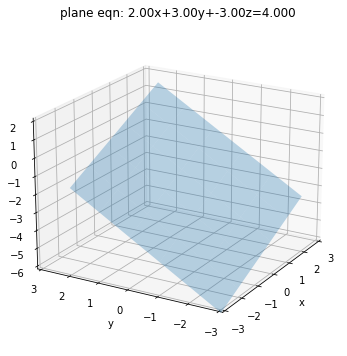

In [5]:
mu = 1.5
peqn = 2 * x + 3 * y - 3 * z - 4
pn = np.array(grad(peqn),dtype=np.float32)
d = -peqn.subs([(x, 0), (y, 0), (z, 0)])
tpeqn = "plane eqn: {:.2f}x+{:.2f}y+{:.2f}z={:.3f}".format(pn[0],pn[1],pn[2],float(d))

xlim = -3,3
ylim = -3,3
zlim = -6,2
xx, yy = np.meshgrid(np.arange(*xlim), np.arange(*ylim))
zz = (d - pn[0] * xx - pn[1] * yy) / pn[2]
#zz[zz>6] = np.nan
#zz[zz<-2] = np.nan

# plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=20, azim=210, roll=0)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)
ax.plot_surface(xx, yy, zz, alpha=0.3, label='tangent plane')
ax.title.set_text(tpeqn)
#ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

This is another gentle reminder that 3D plotting of infinite planes is a challenge for Python, but may be better suited to other applications.

Let's go ahead and create a ray with a parameter "t":

In [6]:
#r = origin + t * v
r1_o = sym.Matrix([[4, 0, 0]])
r1v = sym.Matrix([[-5, 2, 1]])
t = sym.Symbol('t', positive=True) 
r1 = r1_o + t * r1v

We can now ask Python if and where there are intersections between the ray and plane eqaution:

In [7]:
# equate ray with plane, look for intersections
sols = sym.solve(peqn.subs([(x, r1[0]), (y, r1[1]), (z, r1[2])]),t)
if not sols:
    print("No intersections found")
else:
    valid_sols = [i for i in sols if i <= 1]
    valid_sols.sort()
    for i, val in enumerate(valid_sols) :
        print("intersection {} found at t={}".format(i+1,val.evalf()))
    
    #convert intersections to useful datatypes
    is1  = (r1.subs(t,sols[0].evalf()))
    r1o  = np.array(r1_o.tolist()[0],dtype='float64')
    is1a = np.array(is1.tolist()[0],dtype='float64')
    print("intersection occurs at ({:0.3f},{:0.3f},{:0.3f})".format(is1a[0],is1a[1],is1a[2]))
    r1vv  = np.array(r1v.tolist()[0],dtype='float64')
    rr_o = sym.Matrix([is1a])

intersection 1 found at t=0.571428571428571
intersection occurs at (1.143,1.143,0.571)


Now that we have located the intersection point, we can use this as the origin for a new ray equation, generating the direction of this new ray using the subroutine we defined earlier `v(u,n)`:

In [8]:
#construct ray equation for reflected ray:
rr = is1a + t * v(r1vv,pn,mu)
print("reflected ray eq:")
print(rr)

reflected ray eq:
[1.14285714285714 - 7.05122637748718*t
 1.14285714285714 - 1.07683944702148*t
 4.07683944702148*t + 0.571428571428571]


The reflected ray equation obtained above looks good; the vector direction matches that determined in Example 1 in the lectures.

Can we visually confirm that the reflected ray is travelling in the correct direction?

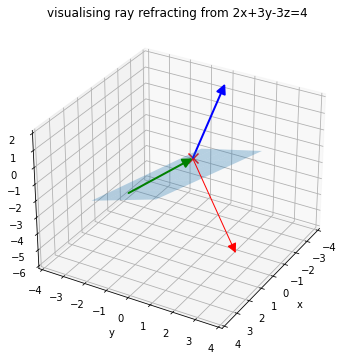

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=30, azim=30, roll=0)
ax.set_zlim(-6,2)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ax.plot_surface(xx, yy, zz, alpha=0.3, label='positive cone')
ax.scatter(is1a[0],is1a[1],is1a[2], c='r', marker='x', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='g', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([r1o[0], is1a[0]], [r1o[1], is1a[1]], [r1o[2], is1a[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([is1a[0], is1a[0]+pn[0]], [is1a[1], is1a[1]+pn[1]], [is1a[2], is1a[2]+pn[2]], **arrow_prop_dict)
ax.add_artist(b)
#to plot reflected ray, pick value of t to create end point for arrow
tep=0.5
ep = [float(rr[0].subs({t:tep})),float(rr[1].subs({t:tep})),float(rr[2].subs({t:tep}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0, linewidth=2)
c = Arrow3D([is1a[0], ep[0]], [is1a[1], ep[1]], [is1a[2], ep[2]], **arrow_prop_dict)
ax.add_artist(c)
ax.title.set_text('visualising ray refracting from 2x+3y-3z=4')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

In the above figure, we can see that the incident ray (green) arrives at the plane (blue) at the intersection point we found (red cross). The normal at the point of intersection (red arrow) appears perpendicular to the plane. The refracted ray (blue arrow) enters the region of space on the opposite side of the plane, bending towards the normal as it should.

### What effect does $\mu$ have?

In the previous example, the value of $mu$ changes the vector direction of the outbound ray as it passes the boundary. Python presents us with a neat opportunity to tinker with the value of the refractive index and visually confirm what effect this has on the result.

From the previous example, let's create a few new refracted rays; we don't need to recalculate intersection locations, as the incident ray is completely independent of the refractive index. All that we need to do is re-use the subroutine we made earlier, evaluating different values of $\mu$. If we do this, what happens to the refracted ray vector?

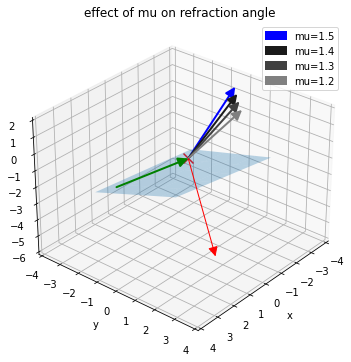

In [10]:
#construct some new ray vectors for different mu values:
rr4 = is1a + t * v(r1vv,pn,1.4)
rr3 = is1a + t * v(r1vv,pn,1.3)
rr2 = is1a + t * v(r1vv,pn,1.2)

# plot setup:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=30, azim=40, roll=0)
ax.set_zlim(-6,2)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ax.plot_surface(xx, yy, zz, alpha=0.3)
ax.scatter(is1a[0],is1a[1],is1a[2], c='r', marker='x', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='g', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([r1o[0], is1a[0]], [r1o[1], is1a[1]], [r1o[2], is1a[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([is1a[0], is1a[0]+pn[0]], [is1a[1], is1a[1]+pn[1]], [is1a[2], is1a[2]+pn[2]], **arrow_prop_dict)
ax.add_artist(b)
ep = [float(rr[0].subs({t:tep})),float(rr[1].subs({t:tep})),float(rr[2].subs({t:tep}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0, linewidth=2, label='mu=1.5')
c = Arrow3D([is1a[0], ep[0]], [is1a[1], ep[1]], [is1a[2], ep[2]], **arrow_prop_dict)
ax.add_artist(c)
ep4 = [float(rr4[0].subs({t:tep})),float(rr4[1].subs({t:tep})),float(rr4[2].subs({t:tep}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='0.1', shrinkA=0, shrinkB=0, linewidth=2, label='mu=1.4')
c4 = Arrow3D([is1a[0], ep4[0]], [is1a[1], ep4[1]], [is1a[2], ep4[2]], **arrow_prop_dict)
ax.add_artist(c4)
ep3 = [float(rr3[0].subs({t:tep})),float(rr3[1].subs({t:tep})),float(rr3[2].subs({t:tep}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='0.25', shrinkA=0, shrinkB=0, linewidth=2, label='mu=1.3')
c3 = Arrow3D([is1a[0], ep3[0]], [is1a[1], ep3[1]], [is1a[2], ep3[2]], **arrow_prop_dict)
ax.add_artist(c3)
ep2 = [float(rr2[0].subs({t:tep})),float(rr2[1].subs({t:tep})),float(rr2[2].subs({t:tep}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='0.5', shrinkA=0, shrinkB=0, linewidth=2, label='mu=1.2')
c2 = Arrow3D([is1a[0], ep2[0]], [is1a[1], ep2[1]], [is1a[2], ep2[2]], **arrow_prop_dict)
ax.add_artist(c2)
ax.title.set_text('effect of mu on refraction angle')
ax.legend(loc="best")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

We can see from the above graph what effect the refractive index, $\mu$, has on the refracted ray vectors. As $\mu$ decreases, the angle of deflection also decreases. This means that as $\mu$ tends to $1$, the refracted ray vector tends towards the initial incident vector ${\bf{\vec{u}}}$. 

$\mu$ is a ratio of the speed of light after a boundary to the speed of light before it - if the speed of light before and after a boundary is the same, there will be no deflection!

## Apparent depth

The other major formula we derived in the lectures considers the **apparent depth**; this is the effect of refraction causing objects to appear closer to the boundary between media than is actually true. 

The common example for this is viewing objects in bodies of water - hunting fish by eye is often hampered by the refraction of light rays, meaning that the fish appear to be in a different place to where they actually are. Note also that this effect is not unique to bodies of water, nor do they have to be depths in a vertical sense; a flaw in a glass window might appear to lie at a "depth" below the surface of the glass, despite actually being located elsewhere.

In the lectures we saw that the apparent depth of an object, $l$, can be related to the true depth $d$ if the incident ray vector ${\mathbf{\vec{u}}}$, surface normal ${\mathbf{\vec{n}}}$ and refractive index $\mu$ are known, as follows:

$$
l = \frac{d}{|\mathbf{\vec{u}}\cdot\mathbf{\vec{n}}|}\sqrt{\left(\mu^2-1\right)|{\mathbf{\vec{u}}}|^2|{\mathbf{\vec{n}}}|^2+\left(\mathbf{\vec{u}}\cdot\mathbf{\vec{n}}\right)^2}.
$$

We'll start by creating another subroutine to calculate this for us:

In [11]:
def l(u,n,mu, d):
    # reads in incident vector u, normal vector n, refractive index mu, depth d
    # calculates apparent depth using formula from lectures
    modus = np.linalg.norm(u) * np.linalg.norm(u)
    modns = np.linalg.norm(n) * np.linalg.norm(n)
    
    temp = (mu * mu - 1.) * modus * modns + u.dot(n) * u.dot(n)
    l = d * np.sqrt(temp) / abs(u.dot(n))
    return l

Let's see this in action using the example from the lectures:

## Lecture example 2: apparent depth

**A ray of light from an object at the bottom of a pool of water has equation:** 

$$
\begin{align}
    {\mathbf{\vec{r}}} &=
          \begin{pmatrix}
           2 \\           
           3 \\
           0
          \end{pmatrix} +t
          \begin{pmatrix}
           1 \\
           -2 \\
           4
         \end{pmatrix}
  \end{align}
$$

**The pool is 3 metres deep with a horizontal base in the $xy$-plane. If the refractive index of water to air is $\mu=2/3$, then calculate (i) the vector equation of the refracted ray in air from the object and (ii) the apparent depth of the pool.**

### Part 1: ray equation
First let's set up the plane equation and rays:

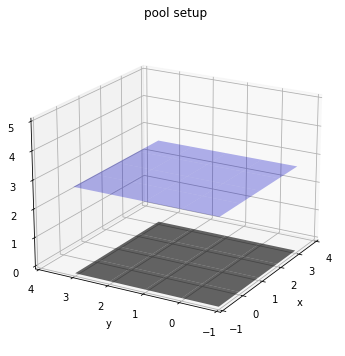

In [12]:
mu2 = 2/3
p1eqn = 0 * x + 0 * y + 1 * z - 3
p1n = -np.array(grad(p1eqn),dtype = np.float32)
d1 = p1eqn.subs([(x, 0), (y, 0), (z, 0)])
tp1eqn = "surface plane eqn: {:.2f}x+{:.2f}y+{:.2f}z={:.3f}".format(p1n[0],p1n[1],p1n[2],float(d))
p2eqn = 0 * x + 0 * y + 1 * z - 0
p2n = -np.array(grad(p2eqn),dtype = np.float32)
d2 = p2eqn.subs([(x, 0), (y, 0), (z, 0)])
tp2eqn = "base plane eqn: {:.2f}x+{:.2f}y+{:.2f}z={:.3f}".format(p2n[0],p2n[1],p2n[2],float(d))

xlim = -1,4
ylim = -1,4
zlim = 0,5
xx2, yy2 = np.meshgrid(np.arange(*xlim), np.arange(*ylim))
zz1 = (d1 - p1n[0] * xx2 - p1n[1] * yy2) / p1n[2]
zz2 = (d2 - p2n[0] * xx2 - p2n[1] * yy2) / p2n[2]

# plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=20, azim=210, roll=0)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)
ax.plot_surface(xx2, yy2, zz1, alpha=0.3, label='surface', color='b')
ax.plot_surface(xx2, yy2, zz2, alpha=0.6, label='base', color='k')
ax.title.set_text("pool setup")
#ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

What about the ray?

In [13]:
#r = origin + t * v
rd_o = sym.Matrix([[2, 3, 0]])
rdv = sym.Matrix([[1, -2, 4]])
t = sym.Symbol('t', positive=True) 
rd = rd_o + t * rdv

Lets set up the rest of the problem, creating a ray, seeking intersection locations and 

In [14]:
# equate ray with plane, look for intersections
sols2 = sym.solve(p1eqn.subs([(x, rd[0]), (y, rd[1]), (z, rd[2])]),t)
if not sols2:
    print("No intersections found")
else:
    valid_sols2 = [i for i in sols2 if i <= 1]
    valid_sols2.sort()
    for i, val in enumerate(valid_sols2) :
        print("intersection {} found at t={}".format(i+1,val.evalf()))
    
    #convert intersections to useful datatypes
    isd  = (rd.subs(t,sols2[0].evalf()))
    rdo  = np.array(rd_o.tolist()[0],dtype='float64')
    isda = np.array(isd.tolist()[0],dtype='float64')
    print("intersection occurs at ({:0.3f},{:0.3f},{:0.3f})".format(is1a[0],is1a[1],is1a[2]))
    rdvv  = np.array(rdv.tolist()[0],dtype='float64')
    rrd_o = sym.Matrix([isda])
    
    #construct ray equation for reflected ray:
    rrd = isda + t * v(rdvv,p1n,mu2)
    print("--")
    print("reflected ray eq:")
    print(rrd)

intersection 1 found at t=0.750000000000000
intersection occurs at (1.143,1.143,0.571)
--
reflected ray eq:
[1.0*t + 2.75 1.5 - 2.0*t 2.08166599273682*t + 3.0]


This reflected ray equation matches the one obtained in lectures.

Let's finally have a go at imaging this particular surface:

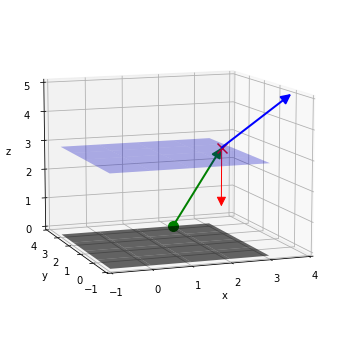

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=10, azim=250, roll=0)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)
ax.plot_surface(xx2, yy2, zz1, alpha=0.3, label='surface', color='b')
ax.plot_surface(xx2, yy2, zz2, alpha=0.6, label='base', color='k')
ax.scatter(isda[0],isda[1],isda[2], c='r', marker='x', s=100) 
ax.scatter(rdo[0],rdo[1],rdo[2], c='g', marker='o', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='g', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([rdo[0], isda[0]], [rdo[1], isda[1]], [rdo[2], isda[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([isda[0], isda[0]+2*p1n[0]], [isda[1], isda[1]+2*p1n[1]], [isda[2], isda[2]+2*p1n[2]], **arrow_prop_dict)
ax.add_artist(b)
tep2=1
ep2 = [float(rrd[0].subs({t:tep2})),float(rrd[1].subs({t:tep2})),float(rrd[2].subs({t:tep2}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0, linewidth=2)
b = Arrow3D([isda[0], ep2[0]], [isda[1], ep2[1]], [isda[2], ep2[2]], **arrow_prop_dict)
ax.add_artist(b)
ax.title.set_text('')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

As expected by now, the incident ray leaves the object (green circle) and intersects the surface at the intersection point identified by Python (red cross). By defining the normal (red arrow) downwards, we see the deflection caused by the refraction of the ray as it leaves the surface (blue arrow).

### Part 2: apparent depth

We also have been asked to calculate the apparent depth of the object. We know from the question that the object is at a true depth of $3~\rm{metres}$, so we would expect the *apparent* depth to be *smaller than this* (the true depth is also the depth of the pool, hence nothing is deeper than this!).

We've already created the vectors in python, so we can use the subroutine we made earlier to complete this calculation:

In [16]:
appdepth = l(rdvv,p1n,2/3, 3)
print("apparent depth=", appdepth, "m")

apparent depth= 1.5612494995995996 m


Is there a way to check this?

One potential way is to pretend the refracted ray travels backwards into the water. If we solve for when this ray lies at the original $x$ or $y$ location of the object, stop the ray, and calculate the distance between the object and it's *image* we can estimate the apparent depth.


In [17]:
#because ray going backwards, t cannot be negative
# make a new variable which *can* be negative:
tau = sym.Symbol('tau') 
rrd[0].subs({t:tau})
tim = sym.solve(rrd[0].subs({t:tau})-2,tau)
print, tim[0]
imloc = [float(rrd[0].subs({t:tim[0]})),float(rrd[1].subs({t:tim[0]})),float(rrd[2].subs({t:tim[0]}))]

Lets check where this is visually, by adding the image to the plot we made earlier:

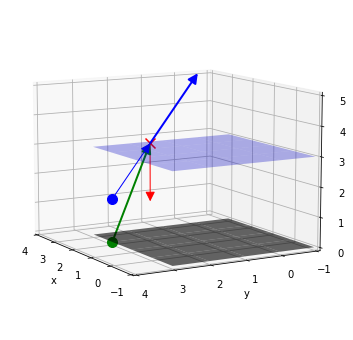

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=10, azim=150, roll=0)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)
ax.plot_surface(xx2, yy2, zz1, alpha=0.3, label='surface', color='b')
ax.plot_surface(xx2, yy2, zz2, alpha=0.6, label='base', color='k')
ax.scatter(isda[0],isda[1],isda[2], c='r', marker='x', s=100) 
ax.scatter(rdo[0],rdo[1],rdo[2], c='g', marker='o', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='g', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([rdo[0], isda[0]], [rdo[1], isda[1]], [rdo[2], isda[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([isda[0], isda[0]+2*p1n[0]], [isda[1], isda[1]+2*p1n[1]], [isda[2], isda[2]+2*p1n[2]], **arrow_prop_dict)
ax.add_artist(b)
tep2=1
ep2 = [float(rrd[0].subs({t:tep2})),float(rrd[1].subs({t:tep2})),float(rrd[2].subs({t:tep2}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0, linewidth=2)
c = Arrow3D([isda[0], ep2[0]], [isda[1], ep2[1]], [isda[2], ep2[2]], **arrow_prop_dict)
ax.add_artist(c)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0, linewidth=1)
c2 = Arrow3D([imloc[0],isda[0]], [imloc[1],isda[1]], [imloc[2],isda[2]], **arrow_prop_dict)
ax.add_artist(c2)
ax.scatter(imloc[0],imloc[1],imloc[2], c='b', marker='o', s=100) 
ax.title.set_text('')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

The blue dot does look like it is in the right location to be the image of the green dot if the water surface didnt exist.

Lets finally calculate the apparent depth of the image:

In [19]:
depth = 3-np.linalg.norm(list(set(imloc)-set([2,3,0])))
print("depth of image backtracing ray:", depth, "m")

depth of image backtracing ray: 1.5612494945526123 m


This value is very close to the value returned by subroutine earlier (but there's likely been some rounding in the equation solving, so they are not identical values).

This verifies the formula we found in the lectures, by taking an example and measuring the distance from the virtual image to the water surface.

## Over to you
The aim of this course is to familiarise and become an expert in the mathematics underpinning several common standard games tools and techniques. You should carry out the questions in the tutorial booklet **by hand** to practice this mathematics and prepare for the exam. However, particularly in this topic, the mathematics is not easily visualised; having completed the maths exercises, try and visualise some of the solutions you have created to verify the ray behaviour. 